# Predicting Startup Success

As investors we want to know which companies will succeed and which companies will fail so we can make smart investments.  Unfortunately there is no way to know ahead of time which companies will succeed or fail, however, we can try to predict success based on the huge amounts of data available online about startups.  For this project we will be analyzing data obtained through the [CrunchBase](https://www.crunchbase.com/) API.

The CrunchBase dataset, while extensive provides us with data that is pretty biased.  In order to be in the CrunchBase database, a company must already have become newsworthy.  Normally that means raising a significant round of funding or graduating from a prominent incubator.  We will take this bias into account when performing our analysis.  Simply raising one round of funding will not be considered a succesful outcome.

So how will we define success?  We will use a couple of indicators, and if a company achieves even a single one of these, we will consider the startup to be successful.  

So what are the indicators we are using? We will consider a company to be a success if it IPOs or if it is acquired (even though we are aware that many acquisitions may not be considered successes by employees or investors in a company, for this project we will be making this simplification and assuming all acquisitions are successes).  We will also consider a startup a success if it has raised several rounds of funding.  How many?  Well, since all the startups in the CrunchBase database have already raised one round, we will pretend we are making a second round investment.  Any companies that raise a thrid round will be considered succesful as they have proven that other investors are interested in investing in this company after us.  Later we will show another reason why we chose 3 as a cutoff in the number of rounds of investment to be considered successful.

Not all companies are equally successful.  And perhaps it is best to weight your investments based on how certain you are that a company will succeed and how succesful that company will be, in terms of what the rate of return for a particular company is.  However, since we don't have all of the financial information for funding rounds, and none of the financial information for rate of return for different investors in different rounds of different companies, we will simply focus in this project on the overall success or failure of a company and treat this as a classification problem, rather than a regression problem.

##Data Cleaning

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import datetime
import time

In [2]:
# Focus on the start up founded before 2010
with open("tmp/organizations_dict_to2010.json", "r") as fd:
    orgs = json.load(fd)

In [3]:
orgs.values()[-10:]

[{u'acquired_by': [],
  u'acquisitions': [],
  u'board_members_and_advisors': [],
  u'categories': [{u'name': u'Security'}],
  u'competitors': [],
  u'founders': [],
  u'funding_rounds': [{u'announced_on': u'2014-04-08',
    u'funding_type': u'venture',
    u'money_raised_usd': 1455200},
   {u'announced_on': u'2011-03-03',
    u'funding_type': u'venture',
    u'money_raised_usd': 192366},
   {u'announced_on': u'2013-05-30',
    u'funding_type': u'seed',
    u'money_raised_usd': 675000},
   {u'announced_on': u'2014-03-26',
    u'funding_type': u'venture',
    u'money_raised_usd': 750000},
   {u'announced_on': u'2012-06-13',
    u'funding_type': u'seed',
    u'money_raised_usd': 1000000},
   {u'announced_on': u'2015-01-13',
    u'funding_type': u'convertible_note',
    u'money_raised_usd': 50000}],
  u'headquarters': [{u'city': u'Burnaby', u'country': u'Canada'}],
  u'investors': [],
  u'ipo': [],
  u'moonth_founded': u'1969-01',
  u'offices': [{u'city': u'Burnaby', u'country': u'Canada'

In [4]:
df=pd.DataFrame(orgs.values(),index=orgs.keys())

Copied this from HW5, to get adjectives and nouns from the short_description

In [6]:
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
# taken from HW5
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2


In [7]:
# If no description we set the short description to 0 to apply the mapping
df['short_description'] = df.short_description.fillna(0)

In [8]:
# add column for description nouns and adjectives
df['text_nouns']=df.short_description.map(lambda x: [] if isinstance(x, int) else get_parts(x)[0]).map(lambda x: [item for sublist in x for item in sublist])
df['text_adjectives']=df.short_description.map(lambda x: [] if isinstance(x, int) else get_parts(x)[1]).map(lambda x: [item for sublist in x for item in sublist])

In [9]:
# add indicator columns for each category
catlist=df.categories.map(lambda x: None if x==None or isinstance(x,float) else [a['name'] for a in x]).tolist()
catset=set([item for sublist  in catlist if sublist!=None for item in sublist])
for category in catset:
    df["c_"+category+"_i"]=pd.Series(catlist, index=df.index).map(lambda x: category in x if x else False)

In [10]:
# add indicator columns for investors
investorslist=df.investors.map(lambda x: None if x==None or isinstance(x,float) else [a['permalink'] for a in x]).tolist()
investorset=set([item for sublist  in investorslist if sublist!=None for item in sublist])
for inv in investorset:
    df["i_"+inv+"_i"]=pd.Series(investorslist, index=df.index).map(lambda x: inv in x if x else False)

In [11]:
# add indicator columns for cities (from offices)
citylist=df.offices.map(lambda x: None if not x or isinstance(x,float) else [a['city'] for a in x]).tolist()
cityset=set([item for sublist  in citylist if sublist!=None for item in sublist])
for city in cityset:
    if city != None:
        df["city_"+city+"_i"]=pd.Series(citylist, index=df.index).map(lambda x: city in x if x else False)

In [12]:
# add indicator columns for headquarter country
countrylist=df.headquarters.map(lambda x: None if not x or isinstance(x,float) else [a['country'] for a in x]).tolist()
countryset=set([item for sublist  in countrylist if sublist!=None for item in sublist])
for country in countryset:
    if country != None:
        df["country_"+country+"_i"]=pd.Series(countrylist, index=df.index).map(lambda x: city in x if x else False)

After adding indicator columns, we now get some more data from the fields that currently exist as dictionaries/lists

In [13]:
df['funding_dates']=df.funding_rounds.map(lambda x:[] if not x or isinstance(x,float) else [datetime.datetime(*time.strptime(a['announced_on'], '%Y-%m-%d')[:3]) for a in x])

In [14]:
df['funding_amounts']=df.funding_rounds.map(lambda x:[] if not x or isinstance(x,float) else [float(a['money_raised_usd']) if a['money_raised_usd'] != None else 0 for a in x])

In [15]:
df['num_funding_rounds']=df.funding_amounts.map(lambda x: len(x))

In [16]:
df['funding_mean']=df.funding_amounts.map(lambda x: np.mean(x))
df['funding_total']=df.funding_amounts.map(lambda x: np.sum(x))

/Users/charlesliu/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [17]:
df['went_ipo']=df.ipo.map(lambda x: True if x else False)

In [18]:
df['was_acquired']=df.acquired_by.map(lambda x: True if x else False)

In [19]:
df['founder_names']=df.founders.map(lambda x:[] if not x or isinstance(x,float) else [a['permalink']  for a in x])
df['num_founders']=df.founders.map(lambda x: np.count_nonzero(x))

In [20]:
df['founder_ages'] = df.founders.map(lambda x:[] if not x or isinstance(x,float) else [(datetime.date.today()-datetime.date(*time.strptime(a['born_on'],'%Y-%m-%d')[:3])).days/365 for a in x if isinstance(a['born_on'],unicode)])
df['founder_ages_mean'] = df.founder_ages.map(lambda x: np.mean(x) if len(x) >0 else 0)
df['num_competitors'] = df.competitors.map(lambda x: np.count_nonzero(x))
df['num_acquisitions'] = df.acquisitions.map(lambda x: np.count_nonzero(x))
df['num_board_members_and_advisors'] = df.board_members_and_advisors.map(lambda x: np.count_nonzero(x))

In [21]:
df.head()

,acquired_by,acquisitions,board_members_and_advisors,categories,competitors,founders,funding_rounds,headquarters,investors,ipo,moonth_founded,offices,short_description,text_nouns,text_adjectives,c_Marketplaces_i,c_Veterinary_i,c_Crowdsourcing_i,c_Data Privacy_i,c_B2B_i,c_Event Management_i,c_Health and Insurance_i,c_Crowdfunding_i,c_Performance Marketing_i,c_Incentives_i,c_Social Television_i,c_Communications Infrastructure_i,c_Collaborative Consumption_i,c_Lighting_i,c_Virtual Currency_i,c_Tourism_i,c_Cloud Data Services_i,c_Training_i,c_Knowledge Management_i,c_Social Media Marketing_i,c_Sensors_i,c_Restaurants_i,c_Interface Design_i,c_Portals_i,c_Independent Music Labels_i,c_Customer Support Tools_i,c_Reviews and Recommendations_i,c_Water Purification_i,c_Flash Storage_i,c_SNS_i,c_Peer-to-Peer_i,c_Telecommunications_i,c_Ticketing_i,c_Freelancers_i,c_Video Streaming_i,...,country_Hong Kong_i,country_Philippines_i,country_Spain_i,country_The Netherlands_i,country_Cayman Islands_i,country_Denmark_i,country_Poland_i,country_Finland_i,country_Mexico_i,country_Moldova_i,country_United States_i,country_Russian Federation_i,country_Sweden_i,country_Latvia_i,country_Thailand_i,country_Switzerland_i,country_Belarus_i,country_New Zealand_i,country_Brazil_i,country_Mauritius_i,country_Romania_i,country_Portugal_i,country_Estonia_i,country_South Africa_i,country_Egypt_i,country_United Arab Emirates_i,country_Uruguay_i,country_Lebanon_i,country_Peru_i,country_United Kingdom_i,country_Malaysia_i,country_Austria_i,country_Vietnam_i,country_Greece_i,country_Japan_i,country_South Korea_i,funding_dates,funding_amounts,num_funding_rounds,funding_mean,funding_total,went_ipo,was_acquired,founder_names,num_founders,founder_ages,founder_ages_mean,num_competitors,num_acquisitions,num_board_members_and_advisors
express-inn-hotel,[],[],[],[{u'name': u'Real Estate'}],[],[],"[{u'announced_on': u'2014-11-19', u'funding_ty...","[{u'city': u'Junction City', u'country': u'Uni...",[],[],2008-08,"[{u'city': u'Junction City', u'country': u'Uni...","Hotel opportunity: Selling 50% equity for $1M,...","[opportunity, equity, partner, salary, profit,...",[50%],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[2014-11-19 00:00:00],[50000.0],1,50000.0,50000,False,False,[],0,[],0,0,0,0
carnegie-robotics,[],[],[],[{u'name': u'Manufacturing'}],[],[],"[{u'announced_on': u'2010-08-24', u'funding_ty...","[{u'city': u'Pittsburgh', u'country': u'United...",[],[],2010-01,"[{u'city': u'Pittsburgh', u'country': u'United...",Carnegie Robotics builds reliable robotics pro...,"[robotic, product, sensor, productivity, relia...","[reliable, smart]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[2010-08-24 00:00:00],[594000.0],1,594000.0,594000,False,False,[],0,[],0,0,0,0
magnetic,[],"[{u'announced_on': u'2014-05-28'}, {u'announce...",[{u'bio': u'Named one of the top 8 up and comi...,"[{u'name': u'Advertising'}, {u'name': u'Ad Tar...",[],"[{u'bio': None, u'permalink': u'josh-shatkin-m...","[{u'announced_on': u'2009-03-16', u'funding_ty...","[{u'city': u'New York', u'country': u'United S...",[{u'bio': u'Jason Finger is a co-founder and w...,[],2008-01,"[{u'city': u'Santa Monica', u'country': u'Unit...",Magnetic is a search retargetin

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, express-inn-hotel to celonova
Columns: 4079 entries, acquired_by to num_board_members_and_advisors
dtypes: bool(4052), float64(3), int64(5), object(19)
memory usage: 8.2+ MB


Ways to improve our cleaning:
* Imputation of the missing value based on the neighborhood: right now we set the missing value to None (and so False in the indicator) maybe we could impute them based on the average value among all the data or among the closest entries.
* We are not considering the short-description. We could try to extract from them the meaningful words (same for the bio, for instance the background of the person)

# EDA

To begin our exploratory data analysis, let's first take a look at how many companies match each of our different success metrics.

In [23]:
# The number of rows of companies in our 2000 sample that were acquired
print "Number of companies that were acquired: %s" % len(df[df.was_acquired == True])
print "Number of companies with at least 1 funding round: %s" % len(df[df.num_funding_rounds > 0])
print "Number of companies that IPOed: %s" % len(df[df.went_ipo == True])

Number of companies that were acquired: 301
Number of companies with at least 1 funding round: 1939
Number of companies that IPOed: 148


Clearly Acquired and IPOed are good indicators, but funding rounds appears to be a prerequisite to making it into the CrunchBase system.  Perhaps we can be more discerning in determining which companies that raised funds are considered succesful, maybe a specific amount or number of rounds.  

Let's take a closer look at funding rounds, specifically total amount raised:

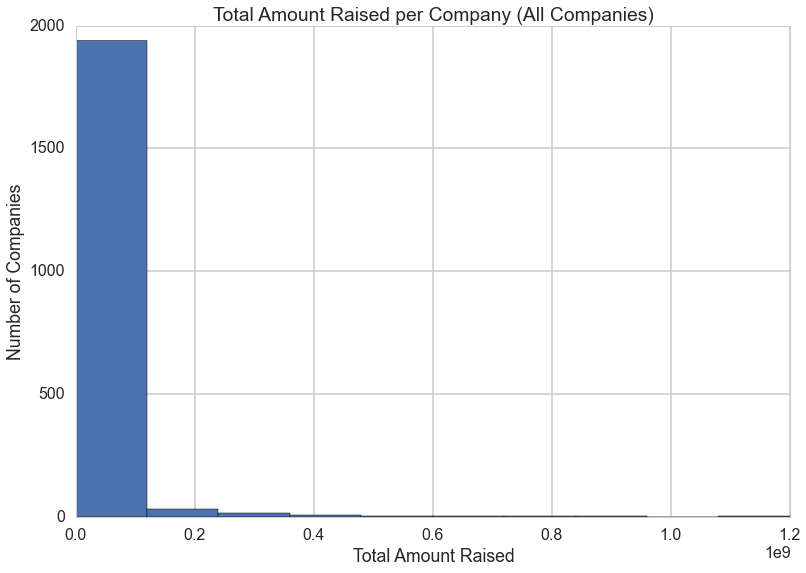

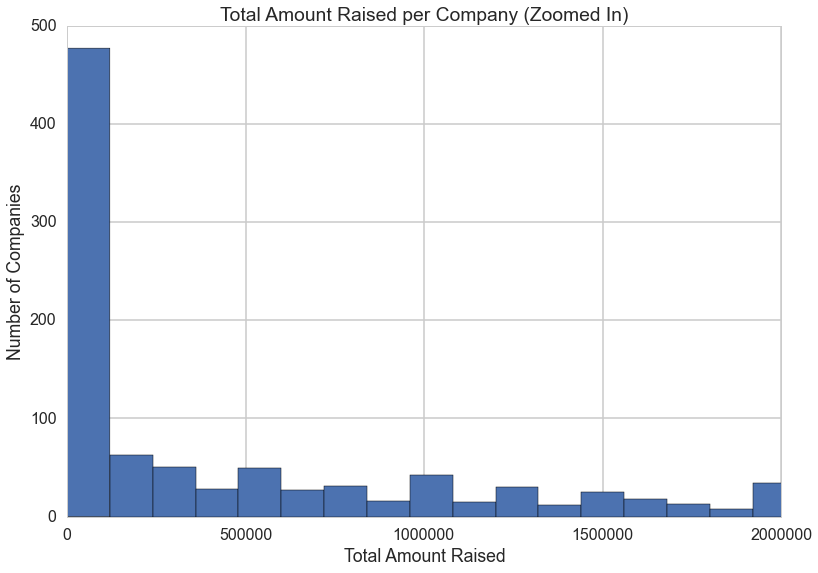

In [25]:
plt.hist(df.funding_total)
plt.title('Total Amount Raised per Company (All Companies)')
plt.xlabel('Total Amount Raised')
plt.ylabel('Number of Companies')
plt.show()

plt.xlim(0,2000000)
plt.hist(df.funding_total, bins=10000)
plt.title('Total Amount Raised per Company (Zoomed In)')
plt.xlabel('Total Amount Raised')
plt.ylabel('Number of Companies')
plt.show()

The majority of companies raised less than $500,000.  The amount of companies that raised a given amount very quickly drops off and goes into a long, sparse tail.  However, since this data is normally private, lots of rounds are missing their amounts.  We need to keep that in mind as we progress with our analysis.  

Let's take a look at the number of rounds each company raised:

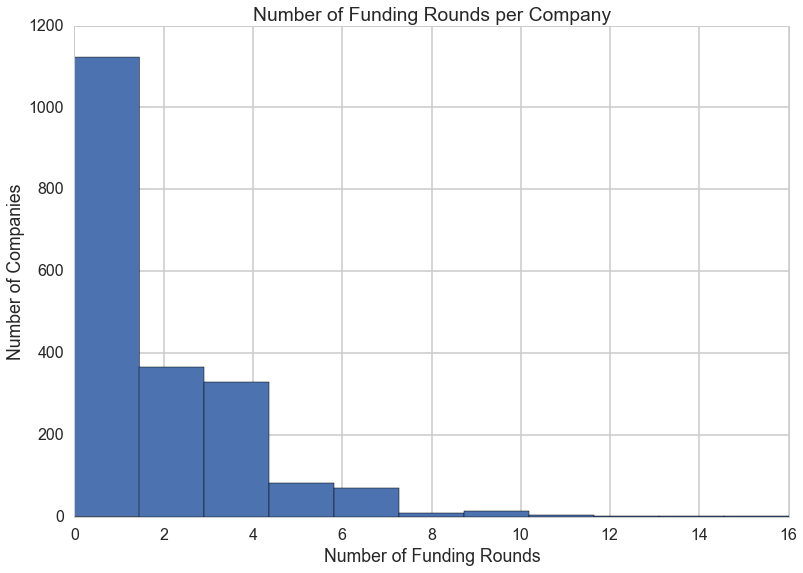

In [26]:
plt.hist(df.num_funding_rounds, bins=11)
plt.title('Number of Funding Rounds per Company')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Number of Companies')
plt.show()

Again, we see that most companies are clustered near the bottom of our range with 0-3 rounds raised.  4 or more rounds raised is not very common.  Perhaps we can use that as an indicator of success, seeing as how it appears to be less sparse than the total amount raised column.  Perhaps this is due to the prevalence of companies and investors announcing that they raised a round, but not disclosing the exact amounts of that round.

Let's see how many companies out of our 2000 had at least 4 rounds:

In [29]:
print "Number of companies that raised at least 4 rounds: %s" % len(df[df.funding_amounts.map(lambda x: len(x) >= 4)])

Number of companies that raised at least 4 rounds: 307


That looks like a good number.  Let's add that as an indicator column to the dataframe, and see how many companies fall into one of our three indicator columns (Acquired, IPOed, > 3 Rounds Raised) now:

In [31]:
df['at_least_4_funding_rounds']=df.funding_amounts.map(lambda x: len(x) >= 4)

In [32]:
# Let's count how many companies match at least one of our success criteria:
print "Number of companies we consider to be a success: %s" % len(df[(df['at_least_4_funding_rounds'] == True) | (df['was_acquired'] == True) | (df['went_ipo'] == True)])

df['success'] = ((df['at_least_4_funding_rounds'] == True) | (df['was_acquired'] == True) | (df['went_ipo'] == True))
df['success'] = df.success.map(lambda x: 1 if x else 0)

Number of companies we consider to be a success: 629


So our success rate is around 31.45%. This may seem like a high success rate when compared to [other metrics about start-up success](http://www.forbes.com/sites/neilpatel/2015/01/16/90-of-startups-will-fail-heres-what-you-need-to-know-about-the-10/), but remember that the companies that make it into CrunchBase are already quite a selective bunch.  As we saw above, most companies in CrunchBase have already raised at least 1 round, so 31% may not seem that high, considering this is already a pretty select crowd of companies.

### Split the data

We'll finish the data cleaning and list the features we don't really need (if we retrieve more data from the API, it will save us time).

Let's split our dataset into training, validation and testing sets.  We need to clean up the columns first and separate the success column from the rest of the data.  We'll also remove any columns that the success column is dependent on (went_ipo, was_acquired, etc....). 

Then we'll split out the testing data from the training data.  
// NOT SURE IF WE DO THIS // We'll then perform a second split on the training data to get the validation data.

In [33]:
# Usable for the Data scrapping part
features_with_only_nan = ['investments', 'owned_by']

In [34]:
cleandf = df.copy()

# Drop unnecessary columns
X = cleandf.drop(['success', 'competitors', 'at_least_4_funding_rounds', 'was_acquired', 'went_ipo', 'funding_total', 'funding_mean', 'acquired_by', 'funding_rounds', 'investors', 'ipo', 'funding_dates', 'num_funding_rounds', 'funding_amounts', 'categories', 'text_nouns', 'text_adjectives', 'short_description', 'founder_ages'], axis=1)
# These columns can probably be converted to numerical form with 
# some positive impact on the models, so don't rule them out 
# completely just yet, but be careful that they are not dependent
# with any of our success indicators
X = X.drop(['acquisitions', 'board_members_and_advisors', 'founders', 'offices', 'headquarters', 'founder_names', 'moonth_founded'], axis=1)
print X.shape

# The success column
y = df['success']
print y.shape
X.head()

(2000, 4055)
(2000,)


,c_Marketplaces_i,c_Veterinary_i,c_Crowdsourcing_i,c_Data Privacy_i,c_B2B_i,c_Event Management_i,c_Health and Insurance_i,c_Crowdfunding_i,c_Performance Marketing_i,c_Incentives_i,c_Social Television_i,c_Communications Infrastructure_i,c_Collaborative Consumption_i,c_Lighting_i,c_Virtual Currency_i,c_Tourism_i,c_Cloud Data Services_i,c_Training_i,c_Knowledge Management_i,c_Social Media Marketing_i,c_Sensors_i,c_Restaurants_i,c_Interface Design_i,c_Portals_i,c_Independent Music Labels_i,c_Customer Support Tools_i,c_Reviews and Recommendations_i,c_Water Purification_i,c_Flash Storage_i,c_SNS_i,c_Peer-to-Peer_i,c_Telecommunications_i,c_Ticketing_i,c_Freelancers_i,c_Video Streaming_i,c_Lead Management_i,c_Sponsorship_i,c_Mobile Payments_i,c_High Schools_i,c_Meeting Software_i,c_3D_i,c_Delivery_i,c_Automotive_i,c_Collaboration_i,c_Software Compliance_i,c_Intellectual Property_i,c_M2M_i,c_Game_i,c_Information Services_i,c_Proximity Internet_i,...,country_Australia_i,country_Indonesia_i,country_Singapore_i,country_El Salvador_i,country_Iceland_i,country_China_i,country_Chile_i,country_Belgium_i,country_Germany_i,country_Hong Kong_i,country_Philippines_i,country_Spain_i,country_The Netherlands_i,country_Cayman Islands_i,country_Denmark_i,country_Poland_i,country_Finland_i,country_Mexico_i,country_Moldova_i,country_United States_i,country_Russian Federation_i,country_Sweden_i,country_Latvia_i,country_Thailand_i,country_Switzerland_i,country_Belarus_i,country_New Zealand_i,country_Brazil_i,country_Mauritius_i,country_Romania_i,country_Portugal_i,country_Estonia_i,country_South Africa_i,country_Egypt_i,country_United Arab Emirates_i,country_Uruguay_i,country_Lebanon_i,country_Peru_i,country_United Kingdom_i,country_Malaysia_i,country_Austria_i,country_Vietnam_i,country_Greece_i,country_Japan_i,country_South Korea_i,num_founders,founder_ages_mean,num_competitors,num_acquisitions,num_board_members_and_advisors
express-inn-hotel,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0
carnegie-robotics,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0
magnetic,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,0,0,3,4
rebounces,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [35]:
from sklearn.cross_validation import train_test_split
# Make the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Split the training data into train/validate set
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.20, random_state=42)


# Training
print X_train.shape
print y_train.shape

# Validate
print X_validate.shape
print y_validate.shape

# Testing
print X_test.shape
print y_test.shape

(1440, 4055)
(1440,)
(360, 4055)
(360,)
(200, 4055)
(200,)


We will save these files now to ensure that we can come back to this point if needed.

In [36]:
X_train.to_csv("tmp/X_train.csv", index=True, header=True, encoding="utf-8")
y_train.to_csv("tmp/y_train.csv", index=True, header=True, encoding="utf-8")

X_validate.to_csv("tmp/X_validate.csv", index=True, header=True, encoding="utf-8")
y_validate.to_csv("tmp/y_validate.csv", index=True, header=True, encoding="utf-8")

X_test.to_csv("tmp/X_test.csv", index=True, header=True, encoding="utf-8")
y_test.to_csv("tmp/y_test.csv", index=True, header=True, encoding="utf-8")

# Bring out the Models

## The Baseline Model

Now we will attempt to find a baseline to improve upon. A basic baseline would be assuming that all companies fail or all companies succeed.  Let's take a look at what those two assumptions would yield.

In [37]:
# Loading the data with the index
X_train = pd.read_csv("tmp/X_train.csv", index_col='Unnamed: 0')
y_train = pd.read_csv("tmp/y_train.csv", index_col='Unnamed: 0').success

X_validate = pd.read_csv("tmp/X_validate.csv", index_col='Unnamed: 0')
y_validate = pd.read_csv("tmp/y_validate.csv", index_col='Unnamed: 0').success

X_test = pd.read_csv("tmp/X_test.csv", index_col='Unnamed: 0')
y_test = pd.read_csv("tmp/y_test.csv", index_col='Unnamed: 0').success

In [38]:
# Assume all companies fail
print "Accuracy of the model assuming all succeed: %s" % (len(y_test[y_test == False]) / (1.0 * len(y_test)))

# Assume all companies succeed
print "Accuracy of the model assuming all fail: %s" % (len(y_test[y_test == True]) / (1.0 * len(y_test)))

Accuracy of the model assuming all succeed: 0.7
Accuracy of the model assuming all fail: 0.3


So the basic baseline to beat is 70%, which we get if we just assume all companies will fail.  That's not so hot.  Let's see if we can beat it.

## K-Nearest Neighbors

Here we will perform a K-Nearest Neighbors classification to predict if a company will be successful or not based upon the training data.  The two categories into which we will be classifying our data are succesful or not succesful.

Here we will use the [scikit-learn](http://scikit-learn.org/stable/modules/neighbors.html) KNeighborsClassifier to perform our classification.  We will start with the with weights set to 'uniform', which is the default and then try some other weighting formulas.

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
validate_accuracy = knc.score(X_validate,y_validate)
print "Validate accuracy with weights = 'uniform' and n_neighbors = 5: %s " % validate_accuracy

Validate accuracy with weights = 'uniform' and n_neighbors = 5: 0.705555555556 


That's not so hot :( 

Perhaps if we increase the number of neigbors to query:

In [40]:
knc = KNeighborsClassifier(n_neighbors=20)
knc.fit(X_train, y_train)
validate_accuracy = knc.score(X_validate,y_validate)
print "Validate accuracy with weights = 'uniform' and n_neighbors = 20: %s" % validate_accuracy

Validate accuracy with weights = 'uniform' and n_neighbors = 20: 0.736111111111


That's better!  We now have a model better than our baseline, although our baseline didn't set too high of a bar to begin with.  Let's graph the n_neighbors by accuracy:

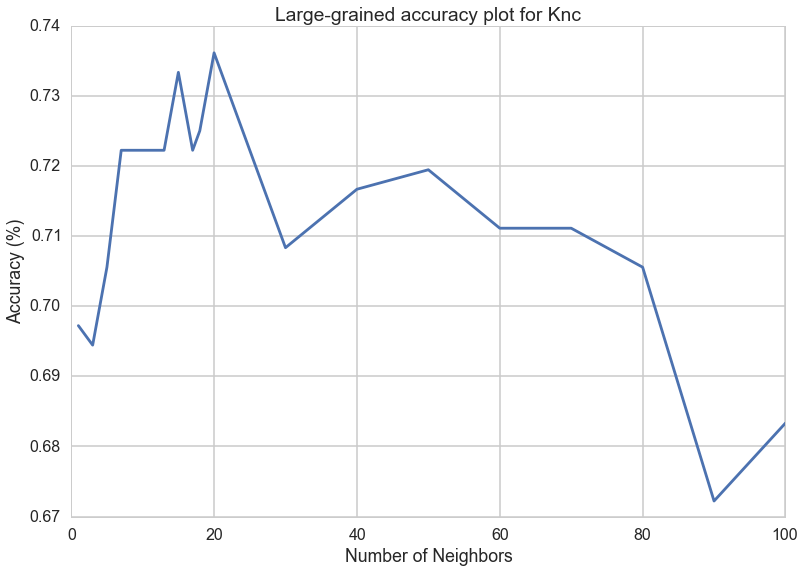

In [42]:
# GRAPH THE N_NEIGBORS (X-AXIS)  BY ACCURACY (Y-AXIS)!
# Large-grained
neighbors=[1,3,5,7,9,11,13,15,17,18,19,20,30,40,50, 60, 70, 80, 90, 100]
accuracies=[]
max_neighbors = 0
max_accuracy = -float("inf")
for n in neighbors:
    knc = KNeighborsClassifier(n_neighbors=n)
    knc.fit(X_train, y_train)
    accuracies.append(knc.score(X_validate,y_validate))
    if accuracies[-1] > max_accuracy:
        max_accuracy = accuracies[-1]
        max_neighbors = n
plt.figure()
plt.plot(neighbors,accuracies)
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy (%)")
plt.title('Large-grained accuracy plot for Knc')
plt.show()

In [45]:
print "Best neighbors was {} with max accuracy of {}".format(max_neighbors, max_accuracy)

Best neighbors was 20 with max accuracy of 0.736111111111


Looks like the best estimate is with 20.

Now we'll try the KNeighborsClassifier with weights='distance':

In [46]:
knc = KNeighborsClassifier(n_neighbors=max_neighbors, weights='distance')
knc.fit(X_train, y_train)
validate_accuracy = knc.score(X_validate,y_validate)
print "Validate accuracy with weights='distance' and n_neighbors = {}: {}".format(max_neighbors, validate_accuracy)

Validate accuracy with weights='distance' and n_neighbors = 20: 0.730555555556


Awesome! 

In [47]:
# Let's see how our test data fares using this KNC
test_accuracy = knc.score(X_test,y_test)
print "Test accuracy with weights='distance' and n_neighbors = {}: {}".format(max_neighbors, test_accuracy)

Test accuracy with weights='distance' and n_neighbors = 20: 0.81


Before with only 1 000 entires without considering the foundation year:

It seems that the model is super sensitive to the train set because the optimal number of neighbors varies a lot between the validation set and the test set (these two sets are both independent from the train data set). This proves that this model is really unstable. 

This may due to the fact that our data are really sparse and we only have a sample of 2000 start ups.

Now:

We reached 0.8 of accuracy which beats the dummy baseline all fails of 0.7!!

## Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegressionCV

# Logistic regression with cross validation on 10-folds
log_reg = LogisticRegressionCV(cv=10, dual=False, penalty='l2', max_iter=1000)
%time log_reg = log_reg.fit(X_train, y_train)

CPU times: user 13min 10s, sys: 12.5 s, total: 13min 22s
Wall time: 4min 5s


In [49]:
test_accuracy = log_reg.score(X_test, y_test)
print "Test accuracy with 10-fold cross val and l2 regularization: %s" % test_accuracy

Test accuracy with 10-fold cross val and l2 regularization: 0.765


We have a better accuracy than in the case where we predict all fail but worse than the knc. When we check on the data, the model predicts a specific configuration.

To refine our evaluation we could plot a ROC curve and evaluate the f1 score.

In [304]:
log_reg.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1])

In [68]:
y_test.values

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1])

Recall: we are looking to invest in companies that we think will be successful. Although we are trying to predict the success of a company, it's a little more nuanced - we are moreso trying to find the next successful company. Recall that the logistic regression identifies a positive with >50% probability threshold. What threshold we choose depends on what is more costly to us - false positives or false negatives?

A false positive would potentially lead to us funding a startup that will eventually fail.
A false negative would potentially lead to us missing out on a startup that's successful.

Although missing out on the next big thing would be unfortunate, if we allocate our money to other startups with some degree of success we won't be losing out on too much (hopefully). Investing in a startup that fails is money gone. From our perspective, a false positive is much costlier, so our probability of success should be much higher than 50%. 

In [50]:
def t_repredict(est, t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [67]:
from sklearn.metrics import confusion_matrix
probs = [.65, .75, .85, .95]
false_pos
print "---"
for prob in probs:
    print "Threshold: {}".format(prob)
    print confusion_matrix(y_test, t_repredict(log_reg, prob, X_test))
    print "---"

---
Threshold: 0.65
[[134   6]
 [ 45  15]]
---
Threshold: 0.75
[[137   3]
 [ 51   9]]
---
Threshold: 0.85
[[138   2]
 [ 53   7]]
---
Threshold: 0.95
[[139   1]
 [ 57   3]]
---


Interestingly, the ratio between false positives to false negatives remains rather consistent in our test set. To be more thorough, let's look at ROC curves.

In [69]:
#taken from HW3
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

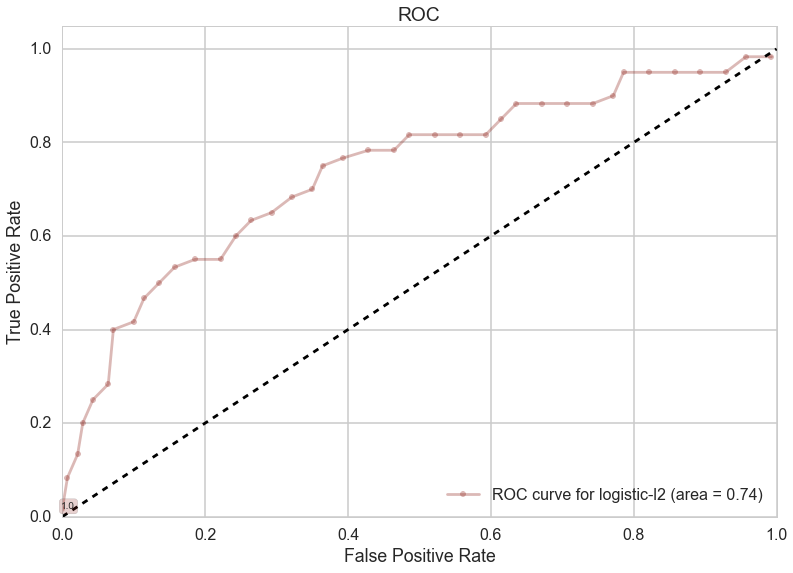

In [73]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-l2",log_reg, y_test, X_test, labe=200, skip=5)

## SVM

In [306]:
from sklearn import svm

# We can try first a linear SVM
clf = svm.SVC(kernel='linear')
%time clf = clf.fit(X_train, y_train)

CPU times: user 12.3 s, sys: 201 ms, total: 12.5 s
Wall time: 13.4 s


In [307]:
test_accuracy = clf.score(X_test, y_test)
print "Test accuracy with kernel='linear': %s" % test_accuracy

Test accuracy with kernel='linear': 0.75


In [308]:
# We can try first a linear SVM
clf = svm.SVC(kernel='rbf')
%time clf = clf.fit(X_train, y_train)

CPU times: user 7.18 s, sys: 76 ms, total: 7.26 s
Wall time: 7.35 s


In [309]:
test_accuracy = clf.score(X_test, y_test)
print "Test accuracy with kernel='rbf': %s" % test_accuracy

Test accuracy with kernel='rbf': 0.72


In [310]:
# We can try first a linear SVM
clf = svm.SVC(kernel='poly')
%time clf = clf.fit(X_train, y_train)

CPU times: user 6.38 s, sys: 47.6 ms, total: 6.43 s
Wall time: 6.51 s


In [311]:
test_accuracy = clf.score(X_test, y_test)
print "Test accuracy with kernel='rbf': %s" % test_accuracy

Test accuracy with kernel='rbf': 0.7


We reached the all fails accuracy here and the model effectiveley predicts all fail.

The best SVM seems to be the linear one

In [312]:
clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Naive Bayes on the short description

Now let's look at whether we can predict success from the presence of certain words in the short description. First, find the top 100 keywords in the short descriptions.

In [92]:
# Import Counter, a library helpful for getting most common values out of a list
from collections import Counter
# get a list of all the adjectives and nouns, and then join them
adjectives=[item for sublist in df.text_adjectives.tolist() for item in sublist] 
nouns=[item for sublist in df.text_nouns.tolist() for item in sublist] 
all_words=adjectives+nouns
# then simply use the most_common function to get the top 100 words and their counts
top_100_words=Counter(all_words).most_common(100)

Then, we create a new dataframe with a column for each of these words, and whether a company's short description contains these words. 

In [98]:
words_df=pd.DataFrame(index=df.index)
for word,count in top_100_words:
    # add column if word appears in adjectives or nouns
    words_df['word_'+word]=df.text_adjectives.map(lambda x: word in x)|df.text_nouns.map(lambda x: word in x)

Now let's set the training, validation, and test data sets using the same indices as above. 

In [168]:
X_train_w=words_df.ix[X_train.index]
X_test_w=words_df.ix[X_test.index]
X_validate_w=words_df.ix[X_validate.index]

We choose to run Bernoulli Naive Baye's as the classifier, since it does best with text classification given binary features for common words. There aren't any hyperparameters to fit.  

In [228]:
from sklearn.naive_bayes import BernoulliNB
nb=BernoulliNB()
nb.fit(X_train_w,y_train_w)
nb.score(X_validate_w,y_validate_w)

0.70833333333333337

This isn't great, because it's barely above the baseline.  


In [212]:
# TODO: figure out whether or not it makes sense to add to ensemble, add more commentary

## Random Forests

Random Forests is often a reliable option for an ensemble classifier, and there are a few hyperparameters we can tune. We'll be iterating over the number of trees to create, and the maximum number of columns to consider for each tree in the random forest. This max_features is supplied as a fraction of the features, which is why the values are between 0 and 1. 

In [227]:
from sklearn.ensemble import RandomForestClassifier
import itertools as it
trees=[5,10,20]
max_features=[.2,.4,.6, 1]

best_score=0
best_params=(0,0)
for tree,max_feat in it.product(trees, max_features):
    rf=RandomForestClassifier()
    rf.fit(X_train,y_train)
    score= rf.score(X_validate,y_validate)
    print "Number of trees:  %d, Max percentage of features used:  %2f, Accuracy: %f" % (tree, max_feat,score)
    if score>best_score:
        best_score=score
        params=(tree, max_feat)
print "\nBest parameters"
print "Number of trees: %d" % params[0]
print "Max percentage of features being used: %f" % params[1]
print "Accuracy of the model: %f " % best_score


Number of trees:  5, Max percentage of features used:  0.200000, Accuracy: 0.727778
Number of trees:  5, Max percentage of features used:  0.400000, Accuracy: 0.713889
Number of trees:  5, Max percentage of features used:  0.600000, Accuracy: 0.738889
Number of trees:  5, Max percentage of features used:  1.000000, Accuracy: 0.738889
Number of trees:  10, Max percentage of features used:  0.200000, Accuracy: 0.744444
Number of trees:  10, Max percentage of features used:  0.400000, Accuracy: 0.744444
Number of trees:  10, Max percentage of features used:  0.600000, Accuracy: 0.736111
Number of trees:  10, Max percentage of features used:  1.000000, Accuracy: 0.730556
Number of trees:  20, Max percentage of features used:  0.200000, Accuracy: 0.750000
Number of trees:  20, Max percentage of features used:  0.400000, Accuracy: 0.722222
Number of trees:  20, Max percentage of features used:  0.600000, Accuracy: 0.722222
Number of trees:  20, Max percentage of features used:  1.000000, Acc

Inherently, these parameters will change because of randomness, but the best random forest classifier will have an accuracy on the validation set of around 75%. 

# Building an Ensemble